In [1]:
from cytorcnn import CytoRCNN, utilities
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
from shapely import dwithin
from shapely.geometry import Polygon
from shapely import errors as se
from shapely.ops import unary_union
from shapely.strtree import STRtree
import time
import pickle

In [2]:
# Tile the big image into 256 by 256 tiles required by CytoRCNN
def tile_original_image(image_path, overlap=64):
    # BGR format
    image = cv2.imread(image_path)
    tile_size = 256
    stride = tile_size - overlap 
    height, width = image.shape[:2]
    pad_width = (tile_size - (width % tile_size)) % tile_size
    pad_height = (tile_size - (height % tile_size)) % tile_size
    padded_image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width,  borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
    padded_height, padded_width = padded_image.shape[:2]
    num_tiles_x = (padded_width - overlap) // stride
    num_tiles_y = (padded_height - overlap) // stride

    # 2D array: tiles[y][x]
    tiles = []
    for y in range(num_tiles_y):
        row_tiles = []
        for x in range(num_tiles_x):
            left = x * stride
            top = y * stride
            right = left + tile_size
            bottom = top + tile_size
            tile = padded_image[top:bottom, left:right]
            row_tiles.append(tile)
        tiles.append(row_tiles)
    return num_tiles_y, num_tiles_x, tiles

def plot_mask_and_save_image(image_path, global_polygons, bbox=None, output_name=None):
    image = mpimg.imread(image_path)
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        image = image[y_min:y_max, x_min:x_max]

    for i, color in zip([0, 1], [(0, 255, 0), (0, 255, 255)]): 
        for polygon in global_polygons[i]:
            points = polygon["points"].astype(int)
            if np.any((points[:, 0] >= x_min) & (points[:, 0] < x_max) &
                      (points[:, 1] >= y_min) & (points[:, 1] < y_max)):
                points = points - np.array([x_min, y_min]) 
                cv2.polylines(image, [points.reshape(-1, 1, 2)], 
                              isClosed=True, color=color, thickness=1)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('on')
    plt.title(f"Cropped Region: ({x_min}, {y_min}) to ({x_max}, {y_max})")
    if output_name is not None:
        plt.savefig(output_name, bbox_inches='tight')
    else:
        plt.show()

# Combines masks of the same type (cell or nuclei) within the same tile
# that overlap - after the masks are predicted from CytoRCNN
def combine_masks_in_tile(type_polygons, category_id):
    polygons = [Polygon(polygon["points"]) for polygon in type_polygons]
    tree = STRtree(polygons)
    merged = set()
    final_polygons = []
    for i in range(len(polygons)):
        if i in merged:
            continue
        polygon_ = polygons[i]
        indices = tree.query(polygon_, predicate="intersects").tolist()
        for index in indices:
            # checks if polygon already merged
            # if index in merged or dwithin(polygons[i].centroid, polygons[index].centroid, 3):
            if index in merged:
                continue
            merged_polygon = polygons[index].union(polygon_)
            if merged_polygon.geom_type == "Polygon":
                polygon_ = merged_polygon
                merged.add(index)
        final_polygons.append({"points": np.array(polygon_.exterior.coords), "category_id": category_id})
    return final_polygons

# Combine masks in current tile that overlaps with an adjacent tile (of the same type)
def combine_masks_across_tiles(tile_1_polygons, tile_2_polygons, category_id):
    tile_1_polygons_ = [Polygon(polygon["points"]) for polygon in tile_1_polygons]
    tile_2_polygons_ = [Polygon(polygon["points"]) for polygon in tile_2_polygons]
    tree = STRtree(tile_1_polygons_)
    deleted = set()
    final_tile_2_polygons = []
    for i in range(len(tile_2_polygons_)):
        polygon_ = tile_2_polygons_[i]
        indices = tree.query(polygon_, predicate="intersects").tolist()
        for index in indices:
            if index in deleted:
                continue
            merged_polygon = tile_1_polygons_[index].union(polygon_)
            if merged_polygon.geom_type == "Polygon":
                polygon_ = merged_polygon
                deleted.add(index)
        final_tile_2_polygons.append({"points": np.array(polygon_.exterior.coords), "category_id": category_id})
    final_tile_1_polygons = [tile_1_polygons[i] for i in range(len(tile_1_polygons)) if i not in deleted]
    return final_tile_1_polygons, final_tile_2_polygons

# Combine cell and nuclei types that are contained within another within a tile
def combine_nuclei_cells_overlap(nuclei, cells):
    nuclei_ = [Polygon(polygon["points"]) for polygon in nuclei]
    cells_ = [Polygon(polygon["points"]) for polygon in cells]
    final_cells = []
    merged_nuclei = set()
    tree = STRtree(nuclei_)
    for i in range(len(cells_)):
        cell = cells_[i]
        indices = tree.query(cell, predicate="contains")
        for index in indices:
            merged_nuclei.add(index)
    final_nuclei = [nuclei[i] for i in range(len(nuclei)) if i not in merged_nuclei]
    return final_nuclei, cells

In [3]:
weights_path = "/u/home/s/syeh/project-hugowill/cytorcnn/model.pth"
image_path = "/u/home/s/syeh/project-hugowill/images/VMI_test.png"

global_polygons = [[], []]
cytorcnn = CytoRCNN(weights_path)

rows, columns, tiles = tile_original_image(image_path)
start = time.time()
prev_index = curr_index = 0
curr_polygons = prev_polygons = [[[],[]]]
# each tile
for d in range(rows + columns - 2):
    for row in range(min(d+1, rows)):
        column = d - row
        if row < rows and column < columns:
            ti = time.time()
            curr_index = d
            # if new diagonal, save prev_index polygons into global_polygons
            # and replace pre_polygons with curr_polygons while curr_polygons
            # becomes empty
            if prev_index != curr_index:
                for row_index in range(len(prev_polygons)):
                    for polygon in prev_polygons[row_index][0]:
                        global_polygons[0].append(polygon)
                    for polygon in prev_polygons[row_index][1]:
                        global_polygons[1].append(polygon)
                prev_polygons = curr_polygons
                curr_polygons = [[[],[]] for i in range(curr_index + 1)]

            data = cytorcnn.predict(tiles[row][column])
            
            annotations = data.get('annotations', [])
            
            # first fix overlap in current tile
            curr_tile_polygons = []
            nuclei_masks = []
            cell_masks = []
            for i in range(len(annotations)):
                segmentation = annotations[i].get('segmentation', None)
                category_id = annotations[i].get('category_id', None)
                num_points = len(segmentation[0])/2

                # (x, y)
                points = np.array(segmentation[0]).reshape(-1, 2).astype(int)
                x_max, y_max = np.max(points, axis=0)
                x_min, y_min = np.min(points, axis=0)
                
                if x_max < 255 and y_max < 255 and x_min > 0 and y_min > 0:
                    points[:, 0] += column * 192
                    points[:, 1] += row * 192
                    if category_id == 0:
                        polygon_data = {"points": points, "category_id": category_id}
                        nuclei_masks.append(polygon_data)
                    elif category_id == 1:
                        polygon_data = {"points": points, "category_id": category_id}
                        cell_masks.append(polygon_data)
            nuclei_masks = combine_masks_in_tile(nuclei_masks, 0)
            cell_masks = combine_masks_in_tile(cell_masks, 1)

            final_nuclei, final_cells = combine_nuclei_cells_overlap(nuclei_masks, cell_masks)
            curr_tile_polygons.append(final_nuclei)
            curr_tile_polygons.append(final_cells)

            # check mask in tile of diagonal with row - 1, col - 1, curr_polygon[index-1]
            if row == 0:
                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], prev_polygons[row][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], prev_polygons[row][1], 1)
                prev_polygons[row] = [prev_nuclei, prev_cells]
            elif column == columns-1:
                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], prev_polygons[row][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], prev_polygons[row][1], 1)
                prev_polygons[row] = [prev_nuclei, prev_cells]
                
                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], prev_polygons[row-1][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], prev_polygons[row-1][1], 1)
                prev_polygons[row-1] = [prev_nuclei, prev_cells]
            elif column == 0:
                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], prev_polygons[row-1][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], prev_polygons[row-1][1], 1)
                prev_polygons[row-1] = [prev_nuclei, prev_cells]

                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], curr_polygons[row-1][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], curr_polygons[row-1][1], 1)
                curr_polygons[row-1] = [prev_nuclei, prev_cells]
            else:
                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], prev_polygons[row][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], prev_polygons[row][1], 1)
                prev_polygons[row] = [prev_nuclei, prev_cells]

                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], prev_polygons[row-1][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], prev_polygons[row-1][1], 1)
                prev_polygons[row-1] = [prev_nuclei, prev_cells]
                
                curr_nuclei, prev_nuclei = combine_masks_across_tiles(curr_tile_polygons[0], curr_polygons[row-1][0], 0)
                curr_cells, prev_cells = combine_masks_across_tiles(curr_tile_polygons[1], curr_polygons[row-1][1], 1)
                curr_polygons[row-1] = [prev_nuclei, prev_cells]
            curr_polygons[row][0] = curr_nuclei
            curr_polygons[row][1] = curr_cells
            print(f"current_index: {curr_index}   row: {row}   column: {column}   time:{time.time() - ti} s")
            prev_index = curr_index
print(f"total_time: {time.time() - start}")

/u/home/s/syeh/.conda/envs/cytorcnn4/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loca

current_index: 0   row: 0   column: 0   time:0.5376780033111572 s
current_index: 1   row: 0   column: 1   time:0.22630095481872559 s
current_index: 1   row: 1   column: 0   time:0.16837143898010254 s
current_index: 2   row: 0   column: 2   time:0.2203679084777832 s
current_index: 2   row: 1   column: 1   time:0.17525863647460938 s
current_index: 2   row: 2   column: 0   time:0.1783607006072998 s
current_index: 3   row: 0   column: 3   time:0.25743603706359863 s
current_index: 3   row: 1   column: 2   time:0.18564653396606445 s
current_index: 3   row: 2   column: 1   time:0.1304481029510498 s
current_index: 3   row: 3   column: 0   time:0.09085988998413086 s
current_index: 4   row: 0   column: 4   time:0.17160391807556152 s
current_index: 4   row: 1   column: 3   time:0.16176891326904297 s
current_index: 4   row: 2   column: 2   time:0.11766314506530762 s
current_index: 4   row: 3   column: 1   time:0.10832047462463379 s
current_index: 4   row: 4   column: 0   time:0.03952288627624512 s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


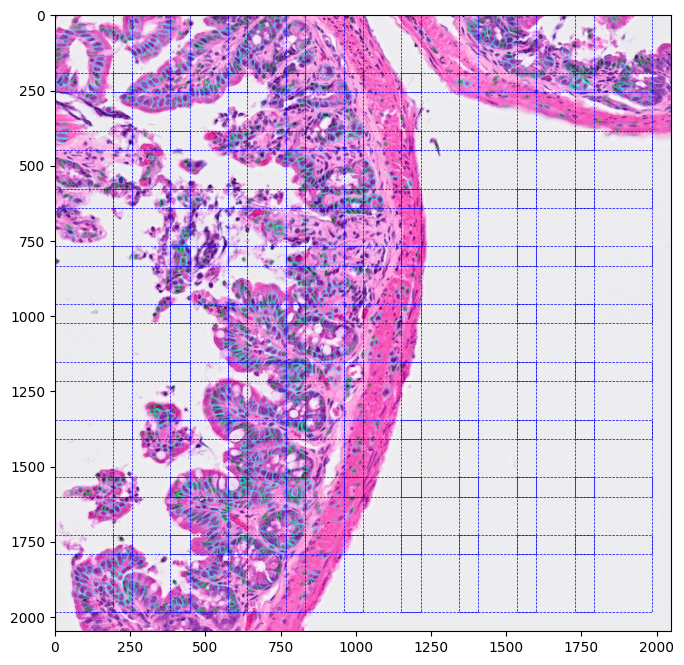

In [5]:
image_path = "/u/home/s/syeh/project-hugowill/images/VMI_test.png"
image = mpimg.imread(image_path)

height, width = image.shape[:2]

grid_size = 256
overlap = 64
stride = grid_size - overlap

x_starts = np.arange(0, width - grid_size + 1, stride)
y_starts = np.arange(0, height - grid_size + 1, stride)

for polygon in global_polygons[0]:
    points = polygon["points"].reshape(-1, 1, 2).astype(int)
    cv2.polylines(image, points, isClosed=True, color=(0, 255, 0), thickness=1)
for polygon in global_polygons[1]:
    points = polygon["points"].reshape(-1, 1, 2).astype(int)
    cv2.polylines(image, points, isClosed=True, color=(0, 255, 255), thickness=1)
        

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('on')

for x in x_starts:
    for y in y_starts:
        rect = plt.Rectangle((x, y), grid_size, grid_size, edgecolor='blue', facecolor='none', linestyle='--', linewidth=0.5)
        plt.gca().add_patch(rect)

# plt.savefig('/u/home/s/syeh/project-hugowill/ipynb/cytorcnn/VMI_test_monocolor.png')
plt.show()